In [1]:
# langgraph_multiagent.py
from langchain.agents import Tool
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional, Dict
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.messages import AIMessage  # import AIMessage
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import CrossEncoder
from langchain_core.tools import tool
import torch
import time
import streamlit as st 
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
import sys

/home/vscode/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

ddg_search = DuckDuckGoSearchResults()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [3]:
model_name = "moonshotai/kimi-k2-instruct" #"openai/gpt-oss-20b"#"qwen/qwen3-32b" #"moonshotai/kimi-k2-instruct"
temperature = 0.3

llm = ChatGroq(
    model_name=model_name,
    temperature=temperature,
    seed=42
)   

/home/vscode/.local/lib/python3.11/site-packages/pydantic/main.py:253: UserWarning: WARNING! seed is not default parameter.
                    seed was transferred to model_kwargs.
                    Please confirm that seed is what you intended.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# Initialize BAAI embeddings with GPU support
embedmodel = "sentence-transformers/all-MiniLM-L6-v2" # You can also use bge-base for smaller but faster model
model_kwargs = {'device': device} # , "trust_remote_code": True
encode_kwargs = {'batch_size': 128, 'device': device, 'normalize_embeddings': True}

embeddings = HuggingFaceEmbeddings(
    model_name=embedmodel,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# --- Cross-Encoder reranker model ---
reranker_model_name = "cross-encoder/ms-marco-TinyBERT-L-2-v2"
reranker = CrossEncoder(reranker_model_name, device=device)



/tmp/ipykernel_6053/2030785957.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


Using device: cpu


In [5]:
# --- Load FAISS vector DB ---
vectordb_vectr = FAISS.load_local(
    "../HPVdb", 
    embeddings, 
    allow_dangerous_deserialization=True
)

In [ ]:
from langgraph_supervisor import create_handoff_tool, create_forward_message_tool

supervisor_handoff = create_handoff_tool(agent_name="Harry Potter Supervisor")

In [6]:
from pydantic import RootModel
from typing import List
from pydantic import BaseModel, Field

class MythologyEntry(BaseModel):
    name: str = Field(..., description="The mythology content name")
    link: str = Field(..., description="The writer/content link")
    reasoning: str = Field(..., description="Reasoning content")
    relation: str = Field(..., description="Relation with Harry Potter")
    gender: str = Field(..., description="Gender")

class MythologyResponse(RootModel[List[MythologyEntry]]):
    pass


from langgraph.prebuilt.chat_agent_executor import AgentStateWithStructuredResponse

In [ ]:
from langgraph_supervisor import create_supervisor

# Create supervisor workflow
workflow = create_supervisor(
    [web_agent, context_agent],
    model=llm,
    prompt = ("""
        **You MUST use both "Harry Potter Retriever Assistant" and "Harry Potter Web Search Assistant" agents to answer the user's question.**
    """),
    #response_format=MythologyResponse,
    #state_schema=AgentStateWithStructuredResponse,  # required for structured_response
    supervisor_name="Harry Potter Supervisor",
    add_handoff_back_messages=True,
    add_handoff_messages=True,    
)

app = workflow.compile()

In [120]:
from typing import Dict,Annotated,List
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import SystemMessage, HumanMessage


class ArticleResponse(TypedDict):
    topic: str
    summary: str
    knowledge: Annotated[list[AnyMessage], add_messages]
    
   

In [121]:
@tool('RetrieveContext')
def retrieve_context(query, n_docs=8):
    """Retrieve documents related to Harry Potter to answer the query"""

    print("Retrieving context...")
    
    # Step 1: Initial similarity search
    retrieved_docs = vectordb_vectr.similarity_search(query, k=10)

    # Step 2: Prepare (query, doc) pairs
    pairs = [(query, doc.page_content) for doc in retrieved_docs]

    # Step 3: Cross-encoder scoring
    scores = reranker.predict(pairs)

    # Step 4: Sort by scores
    reranked = sorted(zip(scores, retrieved_docs), key=lambda x: x[0], reverse=True)
    top_docs = [doc.page_content for _, doc in reranked[:n_docs]]

    return top_docs

print(retrieve_context.invoke({"query": "Friends of Harry Potter","n_docs": 2}))

Retrieving context...
['‘I dunno,’ chuckled Hagrid. ‘Fred and George Weasley could give ’em a run fer their money’\n\n‘You’d have thought Black and Potter were brothers!’ chimed in Professor Flitwick. ‘Inseparable!’\n\n‘Of course they were,’ said Fudge. ‘Potter trusted Black beyond all his other friends. Nothing changed when they left school. Black was best man when James married Lily. Then they named him godfather to Harry. Harry has no idea, of course. You can imagine how the idea would torment him.’\n\n‘Because Black turned out to be in league with You-Know-Who?’ whispered Madam Rosmerta.', '“Potter, you’ve got yourself a girlfriend!” drawled Malfoy. Ginny went scarlet as Ron and Hermione fought their way over, both clutching stacks of Lockhart’s books.\n\n“Oh, it’s you,” said Ron, looking at Malfoy as if he were something unpleasant on the sole of his shoe. “Bet you’re surprised to see Harry here, eh?”\n\n“Not as surprised as I am to see you in a shop, Weasley,” retorted Malfoy. “I

In [122]:
@tool("DuckDuckGoSearch")
def ddg_search_tool(query: str, num_results: int = 5):
    """Perform a DuckDuckGo web search and return results."""

    print("Searching DuckDuckGo...")

    # Call the existing DuckDuckGoSearchResults tool
    results = ddg_search.run(query)

    # If ddg_search.run returns a string, wrap it in a list
    if isinstance(results, str):
        return [results]

    # If it’s already a list/dict, return top results
    if isinstance(results, list):
        return results[:num_results]

    return results


print(ddg_search_tool.invoke({"query": "Friends of Harry Potter ?", "num_results": 5}))

Searching DuckDuckGo...
['snippet: Fred and George Weasley are characters in the Harry Potter series of novels by J. K. Rowling. They are identical twin brothers of the Weasley family, which also includes Ron Weasley and Ginny Weasley., title: Fred and George Weasley - Wikipedia, link: https://en.m.wikipedia.org/wiki/Fred_and_George_Weasley, snippet: Learn all about the upcoming Harry Potter TV series.Her courage, loyalty and kindness earned her place in Harry ’s circle of most trusted friends ., title: Luna Lovegood | Official Harry Potter Encyclopedia, link: https://www.harrypotter.com/fact-file/characters-and-pets/luna-lovegood, snippet: Sirius Black was James Potter ’s closest friend , Harry Potter ’s godfather, and an Animagus, who was falsely accused of betrayal and murder and imprisoned in Azkaban., title: Sirius Black – Harry Potter Lexicon, link: https://www.hp-lexicon.org/character/black-family/sirius-black/, snippet: 1. Harry Potter and Ron Weasley: The bond between Harry an

In [123]:
def webAgent(state):
    print("Web Agent..")
    web_agent = create_react_agent(
            model=llm,
            tools=[ddg_search_tool],
            prompt=(
                """
                **Use both 'DuckDuckGoSearch' tool to answer the query.\n**
                You Must use the search results to answer the query. and provide source links.
                """
            ),
            name="Harry Potter Web Search Assistant",
        )

    ai_content = ""
    result = web_agent.invoke({"messages": [{"role": "user", "content": state['topic']}]})
    output = result["messages"][-1]
    if isinstance(output, AIMessage):
        ai_content = output.content

    return {"knowledge": [f"[Info from Web Search]\n{ai_content}\n\n"]}

In [124]:
def contextAgent(state):
    print("Context Agent..")
    context_agent = create_react_agent(
        model=llm,
        tools=[retrieve_context],
        prompt=(
            """
            **Use both 'RetrieveContext' tools to answer the query.\n**
            You Must use the context to answer the query.
            """
        ),
        name="Harry Potter Retriever Assistant",
    )

    ai_content = ""
    result = web_agent.invoke({"messages": [{"role": "user", "content": state['topic']}]})
    output = result["messages"][-1]
    if isinstance(output, AIMessage):
        ai_content = output.content

    return {"knowledge": [f"[Info from Database]\n{ai_content}\n\n"]}

In [125]:
def summaryAgent(state):
    context = f"Summarize this topic : {state['topic']} based on below context: {state['knowledge']}"

    print(f"\n------------------\n")
    for msg in state["knowledge"]:
        print(f"\n{msg.content}\n")
        print(f"\n------------------\n")
    print("\n------------------\n")

    response = llm.invoke([
        SystemMessage(content="You are a summary assistant"),
        HumanMessage(content=context)
    ])
    return {"summary": response.content}

In [126]:
from langgraph.graph import StateGraph, END, START
from IPython.display import Image, Markdown, display

In [127]:
graph = StateGraph(ArticleResponse)
graph.add_node("webAgent", webAgent)
graph.add_node("contextAgent", contextAgent)
graph.add_node("summaryAgent", summaryAgent)


graph.add_edge(START, "contextAgent")
graph.add_edge(START, "webAgent")
graph.add_edge("contextAgent", "summaryAgent")
graph.add_edge("webAgent", "summaryAgent")
graph.add_edge("summaryAgent", END)

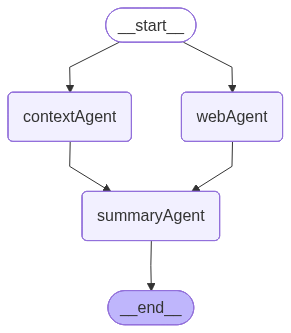

In [128]:
workflow = graph.compile()

Image(workflow.get_graph().draw_mermaid_png())

In [129]:
for step in workflow.stream({"topic": "Top 10 Enemies of Harry Potter ?"}):
    print(step)

display(Markdown(f"## Summary : {list(step.values())[0]['summary']}"))

Context Agent..
Web Agent..


Searching DuckDuckGo...
Searching DuckDuckGo...
Searching DuckDuckGo...
Searching DuckDuckGo...
Searching DuckDuckGo...
Searching DuckDuckGo...
{'contextAgent': {'knowledge': ["[Info from Database]\nBased on my research, here are the **Top 10 Enemies of Harry Potter**:\n\n## **1. Lord Voldemort** \nThe main antagonist and Harry's ultimate nemesis. He murdered Harry's parents and repeatedly tries to kill Harry throughout the series.\n\n## **2. Bellatrix Lestrange**\nOne of Voldemort's most loyal Death Eaters, responsible for killing Sirius Black and torturing Neville's parents.\n\n## **3. Dolores Umbridge**\nA Ministry of Magic official who becomes Defense Against Dark Arts teacher, known for her cruel punishment methods and authoritarian rule at Hogwarts.\n\n## **4. Draco Malfoy**\nHarry's school rival who becomes a Death Eater, constantly bullying Harry and his friends throughout their years at Hogwarts.\n\n## **5. Lucius Malfoy**\nDraco's father, a high-ranking Death Eater who uses h

## Summary : Top 10 Enemies of Harry Potter (concise):

1. Lord Voldemort – Dark Lord who killed Harry’s parents and repeatedly tries to kill him.  
2. Bellatrix Lestrange – Fanatical Death Eater; murdered Sirius Black and tortured the Longbottoms.  
3. Dolores Umbridge – Sadistic Ministry bureaucrat who enforces brutal rules at Hogwarts.  
4. Draco Malfoy – School rival who becomes a Death Eater and bullies Harry throughout.  
5. Lucius Malfoy – Wealthy Death Eater who uses influence to aid Voldemort.  
6. Peter Pettigrew (Wormtail) – Former friend who betrayed Harry’s parents to Voldemort.  
7. Severus Snape – Antagonistic teacher whose actions indirectly caused Lily and James’s deaths (though ultimately protecting Harry).  
8. Barty Crouch Jr. – Death Eater who impersonates Moody and manipulates the Triwizard Tournament.  
9. Fenrir Greyback – Werewolf who attacks children to recruit them, including Remus Lupin.  
10. Quirinus Quirrell – First-year professor who hosts Voldemort’s spirit and tries to kill Harry.